In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import sys
import string
from io import StringIO
import re

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

In [2]:
# From SAM/BAM files
# Each CIGAR string is a series of operations and lengths,and each operation is followed by the length of the operation.
# a CIGAR string 10M2I3D represents an alignment with 10 matches, 2 insertions, and 3 deletions. 
def cigarToList(cigar):
    ''' Parse CIGAR string into a list of CIGAR operations.  For more
        info on CIGAR operations, see SAM spec:
        http://samtools.sourceforge.net/SAMv1.pdf '''
    ret, i = [], 0
    op_map = {'M':0, # match or mismatch
              '=':0, # match
              'X':0, # mismatch
              'I':1, # insertion in read w/r/t reference
              'D':2, # deletion in read w/r/t reference
              'N':3, # long gap due e.g. to splice junction
              'S':4, # soft clipping due e.g. to local alignment(clipped sequence present in SEQ)
              'H':5, # hard clipping (clipped sequence not present in SEQ)
              'P':6} # padding
    # Seems like = and X together are strictly more expressive than M.
    # Why not just have = and X and get rid of M?  Space efficiency,
    # mainly.  The titans discuss: http://www.biostars.org/p/17043/
    while i < len(cigar):
        run = 0
        while i < len(cigar) and cigar[i].isdigit():
            # parse one more digit of run length
            run *= 10
            run += int(cigar[i])
            i += 1
        assert i < len(cigar)
        # parse cigar operation
        op = cigar[i]
        i += 1
        assert op in op_map
        # append to result
        ret.append([op_map[op], run])#op_map[op] maps the CIGAR operation character to its integer code, run is the parsed run length for the operation.
    return ret

In [3]:
def mdzToList(md):
    ''' Parse MD:Z string into a list of operations, where 0=match,
        1=read gap, 2=mismatch. '''
    i = 0;
    ret = [] # list of (op, run, str) tuples
    while i < len(md):
        if md[i].isdigit(): # stretch of matches
            run = 0
            while i < len(md) and md[i].isdigit():
                run *= 10
                run += int(md[i])
                i += 1 # skip over digit
            if run > 0:
                ret.append([0, run, ""])
        elif md[i].isalpha(): # stretch of mismatches
            mmstr = ""
            while i < len(md) and md[i].isalpha():
                mmstr += md[i]
                i += 1
            assert len(mmstr) > 0
            ret.append([1, len(mmstr), mmstr])
        elif md[i] == "^": # read gap
            i += 1 # skip over ^
            refstr = ""
            while i < len(md) and md[i].isalpha():
                refstr += md[i]
                i += 1 # skip over inserted character
            assert len(refstr) > 0
            ret.append([2, len(refstr), refstr])
        else:
            raise RuntimeError('Unexpected character in MD:Z: "%d"' % md[i])
    return ret

In [4]:
def cigarMdzToStacked(seq, cgp, mdp_orig):
    ''' Takes parsed CIGAR and parsed MD:Z, generates a stacked alignment:
        a pair of strings with gap characters inserted (possibly) and where
        characters at at the same offsets are opposite each other in the
        alignment.  Only knows how to handle CIGAR ops M=XDINSH right now.
    '''
    mdp = mdp_orig[:]
    rds, rfs = [], []
    mdo, rdoff = 0, 0
    for c in cgp:
        op, run = c
        skipping = (op == 4 or op == 5)
        assert skipping or mdo < len(mdp)
        if op == 0: # CIGAR op M, = or X
            # Look for block matches and mismatches in MD:Z string
            mdrun = 0
            runleft = run
            while runleft > 0 and mdo < len(mdp):
                op_m, run_m, st_m = mdp[mdo]
                run_comb = min(runleft, run_m)
                runleft -= run_comb
                assert op_m == 0 or op_m == 1
                rds.append(seq[rdoff:rdoff + run_comb])
                if op_m == 0: # match from MD:Z string
                    rfs.append(seq[rdoff:rdoff + run_comb])
                else: # mismatch from MD:Z string
                    assert len(st_m) == run_comb
                    rfs.append(st_m)
                mdrun += run_comb
                rdoff += run_comb
                # Stretch of matches in MD:Z could span M and I CIGAR ops
                if run_comb < run_m:
                    assert op_m == 0
                    mdp[mdo][1] -= run_comb
                else:
                    mdo += 1
        elif op == 1: # CIGAR op I
            rds.append(seq[rdoff:rdoff + run])
            rfs.append("-" * run)
            rdoff += run
        elif op == 2: # D
            op_m, run_m, st_m = mdp[mdo]
            assert op_m == 2
            assert run == run_m
            assert len(st_m) == run
            mdo += 1
            rds.append("-" * run)
            rfs.append(st_m)
        elif op == 3: # N
            rds.append("-" * run)
            rfs.append("-" * run)
        elif op == 4: # S
            rds.append(seq[rdoff:rdoff + run].lower())
            rfs.append(' ' * run)
            rdoff += run
        elif op == 5: # H
            rds.append('!' * run)
            rfs.append(' ' * run)
        elif op == 6: # P
            raise RuntimeError("Don't know how to handle P in CIGAR")
        else:
            raise RuntimeError('Unexpected CIGAR op: %d' % op)
    assert mdo == len(mdp)
    return ''.join(rds), ''.join(rfs)

In [19]:
data_path = '/Users/haokai/Desktop/Github repository/Processed data/Fig. 4/'

In [20]:
# The edit state of reference_plasmid is 001011011100 
samPath = ['WntR_Rep1.sam','WntR_Rep2.sam','WntR_Rep3.sam','WntR_Control.sam','Reference_plasmid.sam']

In [21]:
# extract relevant information from the SAM file and make stacked alignments

multi_align = []
not_aligned = []
for p in samPath:
  multi_al = []
  not_al = []
  with open(data_path+p) as fp:
      for c,ln in enumerate(fp):
        if ln[0] != '@':
          qname, flag, rname, pos, mapq, cigar, rnext, \
          pnext, tlen, seq, qual, extras = str.split(ln, '\t', 11)
          MDZ = re.findall('MD:Z:(.*?)\t',extras)
          if len(MDZ) != 1:
            not_al.append([c,len(MDZ)])
          else:
            multi_al.append([c,cigarMdzToStacked(seq, cigarToList(cigar), mdzToList(MDZ[0])),int(pos)])
  multi_align.append(multi_al)
  not_aligned.append(not_al)

In [22]:
#extracting full-length barcode sequences based on specific 5' (ref_5p) and 3' (ref_3p) reference sequences from aligned reads in multi_align
ref_5p = 'agcgaaTGCC'.upper()
ref_3p = 'AACTcccttt'.upper()

al = []
for sample in range(5):
  complete_5p = np.array([ref_5p in multi_align[sample][i][1][1].replace('-','') for i in range(len(multi_align[sample]))])
  complete_3p = np.array([ref_3p in multi_align[sample][i][1][1].replace('-','') for i in range(len(multi_align[sample]))])

  full_length = complete_5p*complete_3p
  arr_len = []
  for i, read in enumerate(multi_align[sample]):
    if full_length[i]:
      pattern_5p = 'A-*G-*C-*G-*A-*A-*T-*G-*C-*C'
      pattern_3p = 'A-*A-*C-*T-*C-*C-*C-*T-*T-*T'
      start = re.search(pattern_5p, read[1][1]).end()
      end = re.search(pattern_3p, read[1][1]).start()
      arr_len.append(len(read[1][0][start:end].replace('-','')))

  al.append(arr_len)

In [23]:
samPath

['WntR_Rep1.sam',
 'WntR_Rep2.sam',
 'WntR_Rep3.sam',
 'WntR_Control.sam',
 'Reference_plasmid.sam']

In [24]:
# Sample names corresponding to each list in `al`
sample_names = ['WntR_Rep1', 'WntR_Rep2', 'WntR_Rep3', 'WntR_Control', 'Reference_plasmid']

# Create a dictionary where each sample is a column
al_dict = {sample_names[i]: al[i] for i in range(len(sample_names))}

# Convert to a DataFrame (this creates a long format where missing values are NaN)
df_al = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in al_dict.items()]))

# Print the DataFrame
df_al

,WntR_Rep1,WntR_Rep2,WntR_Rep3,WntR_Control,Reference_plasmid
0,415.0,416.0,418.0,417.0,420
1,415.0,416.0,413.0,416.0,416
2,452.0,417.0,416.0,417.0,416
3,417.0,417.0,382.0,416.0,419
4,418.0,413.0,418.0,416.0,416
...,...,...,...,...,...
2066,NaN,NaN,NaN,NaN,419
2067,NaN,NaN,NaN,NaN,416
2068,NaN,NaN,NaN,NaN,521
2069,NaN,NaN,NaN,NaN,416


In [25]:
df_al.count()

WntR_Rep1            1086
WntR_Rep2            1345
WntR_Rep3            1223
WntR_Control         1541
Reference_plasmid    2071
dtype: int64

Color 1: (0.10231025194333628, 0.13952898866828906, 0.2560120319409181)
Color 2: (0.10594361078604106, 0.3809739011595331, 0.27015111282899046)
Color 3: (0.4106130272672762, 0.48044780541672255, 0.1891154277778484)
Color 4: (0.7829183382530567, 0.48158303462490826, 0.48672451968362596)
Color 5: (0.8046168329276406, 0.6365733569301846, 0.8796578402926125)
Color 6: (0.7775608374378459, 0.8840392521212448, 0.9452007992345052)


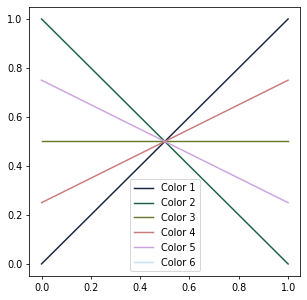

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom palette using the cubehelix palette with 5 colors
custom_palette = sns.color_palette("cubehelix", 6)

# Access individual colors
color_1 = custom_palette[0]
color_2 = custom_palette[1]
color_3 = custom_palette[2]
color_4 = custom_palette[3]
color_5 = custom_palette[4]
color_6 = custom_palette[5]

# Print the RGB values of the colors
print("Color 1:", color_1)
print("Color 2:", color_2)
print("Color 3:", color_3)
print("Color 4:", color_4)
print("Color 5:", color_5)
print("Color 6:", color_6)

# Example plot using individual colors
plt.figure(figsize=(5, 5), dpi=70)

# Plotting with individual colors from the custom palette
plt.plot([0, 1], [0, 1], color=color_1, label='Color 1')
plt.plot([0, 1], [1, 0], color=color_2, label='Color 2')
plt.plot([0, 1], [0.5, 0.5], color=color_3, label='Color 3')
plt.plot([0, 1], [0.25, 0.75], color=color_4, label='Color 4')
plt.plot([0, 1], [0.75, 0.25], color=color_5, label='Color 5')
plt.plot([1, 1], [1, 1], color=color_6, label='Color 6')

# Adding legend and displaying the plot
plt.legend()
plt.show()

In [28]:
# Set the font properties
plt.rcParams.update({
    'font.family': 'Arial',     # Set the font family
    'font.size': 12,            # Set the base font size
    'axes.titlesize': 16,       # Set the font size of the axes title
    'axes.labelsize': 16,       # Set the font size of the x and y labels
    'xtick.labelsize': 12,      # Set the font size of the x tick labels
    'ytick.labelsize': 12,      # Set the font size of the y tick labels
    'legend.fontsize': 12,      # Set the font size of the legend
    'figure.titlesize': 16      # Set the font size of the figure title
})

# Fig 4B

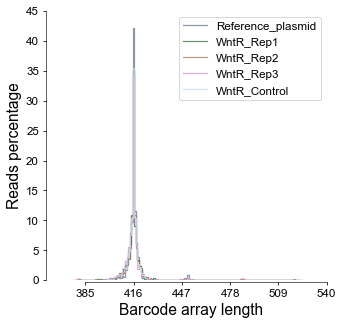

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

custom_palette = sns.color_palette("cubehelix", 5)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(5, 5), dpi=70)

# Plot the histograms with specified colors
#sns.histplot(al[4], discrete=True, stat='percent', element='step', alpha=1, fill=False, ax=ax, color=custom_palette[0], label='BC8_array', linewidth=1)
sns.histplot(al[4], discrete=True, stat='percent', element='step', alpha=0.5, fill=False, ax=ax, color=custom_palette[0], label='Reference_plasmid', linewidth=1.25, multiple="stack")
sns.histplot(al[0], discrete=True, stat='percent', element='step', alpha=0.75, fill=False, ax=ax, color=custom_palette[1], label='WntR_Rep1', linewidth=1.25, multiple="stack")
sns.histplot(al[1], discrete=True, stat='percent', element='step', alpha=0.75, fill=False, ax=ax, color=custom_palette[2], label='WntR_Rep2', linewidth=1.25, multiple="stack")
sns.histplot(al[2], discrete=True, stat='percent', element='step', alpha=0.75, fill=False, ax=ax, color=custom_palette[3], label='WntR_Rep3', linewidth=1.25, multiple="stack")
sns.histplot(al[3], discrete=True, stat='percent', element='step', alpha=0.75, fill=False, ax=ax, color=custom_palette[4], label='WntR_Control', linewidth=1.25, multiple="stack")



# Customize the plot
ax.set_xlabel("Barcode array length")
ax.set_ylabel("Reads percentage")

# Adjust the tick labels rotation
plt.xticks(ticks=np.arange(385, 541, 31), rotation=45)
plt.yticks(ticks=np.arange(0, 50, 5), rotation=45)
# Remove the top and right spines
sns.despine(trim=True, offset={'left': 10, 'bottom': 2})

# Adjust the layout to make room for the rotated labels
#plt.tight_layout()

# Add the legend
plt.legend(loc='upper right')
plt.gca().spines['top'].set_linewidth(0.625)
plt.gca().spines['right'].set_linewidth(0.625)
plt.gca().spines['bottom'].set_linewidth(0.625)
plt.gca().spines['left'].set_linewidth(0.625)
#save_path = os.path.join(dirPath, '240219_barcode array stablitity.svg')
#plt.savefig(save_path, dpi=300, format='svg', transparent=True)
# Show the plot
plt.show()